# Семинар 4. Линейные модели в задачах классификации

Подключение библиотек. 
$
\newcommand{\R}{\mathbb{R}}
\newcommand{\X}{\mathbb{X}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\abs}[1]{\left| #1 \right|}
\newcommand{\E}{\mathbb{E}}
\newcommand{\D}{\mathbb{D}}
\renewcommand{\Prob}{\mathbb{P}}
\renewcommand{\le}{\leqslant}
\renewcommand{\ge}{\geqslant}
\newcommand{\eps}{\varepsilon}
\newcommand{\Normal}{\mathcal{N}}
$

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as wg

from matplotlib.colors import ListedColormap

RdGn = ListedColormap(['red', 'green'])
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
from sklearn.datasets import make_classification, make_circles
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [18]:
# вспомогательная функция
def plot_classification(X, y, model, show_line=False, title='', X_transform=None):
    X_pred = X_transform(X) if X_transform is not None else X
    pred = model.predict(X_pred)
    
    idx = (y == pred) & (y == 1)
    plt.scatter(X[idx, 0], X[idx, 1], color='green', label='true=1, pred=1')

    idx = (y != pred) & (y == 1)
    plt.scatter(X[idx, 0], X[idx, 1], color='blue', label='true=1, pred=0')

    idx = (y == pred) & (y == 0)
    plt.scatter(X[idx, 0], X[idx, 1], color='red', label='true=0, pred=0')

    idx = (y != pred) & (y == 0)
    plt.scatter(X[idx, 0], X[idx, 1], color='yellow', label='true=0, pred=1')

    X1, X2 = X[:, 0], X[:, 1]
    X1 = np.linspace(X1.min(), X1.max(), 128)
    X2 = np.linspace(X2.min(), X2.max(), 128)
    X1, X2 = np.meshgrid(X1, X2)
    Z = np.c_[X1.flatten(), X2.flatten()]
    Z = X_transform(Z) if X_transform is not None else Z
    Z = model.predict(Z).reshape(X1.shape)

    x_plt = np.linspace(X1.min(), X1.max(), 2)
    y_plt = -(model.intercept_[0] + model.coef_[0, 0] * x_plt) / model.coef_[0, 1]
    plt.contourf(X1, X2, Z, levels=2, cmap=RdGn, alpha=0.05)
    if show_line:
        plt.plot(x_plt, y_plt, color='purple', label='Разделяющяя прямая')
    plt.title(title)
    plt.legend()

Изучим логистическую регрессию на примере синтетических данных.

Сгенерируем выборку размера $N = 1024$ из двухмерного нормального распределения $$X_1, \ldots, X_N \sim \Normal(0, I^{2x2}).$$

В качестве целевой переменной рассмотрим $$ y = (y_1, \ldots, y_N), \quad y_k = [2 x_{k1} - 3 x_{k2} + \eps_k > 0], \quad \eps_k \sim \Normal(0, 1a).$$

In [4]:
N = 1024
d = 2

np.random.seed(42)

X = np.random.normal(size=(N, d))
y = (2 * X[:, 0] - 3 * X[:, 1] + np.random.normal(scale=1, size=N) > 1).astype(int)

Построим график:

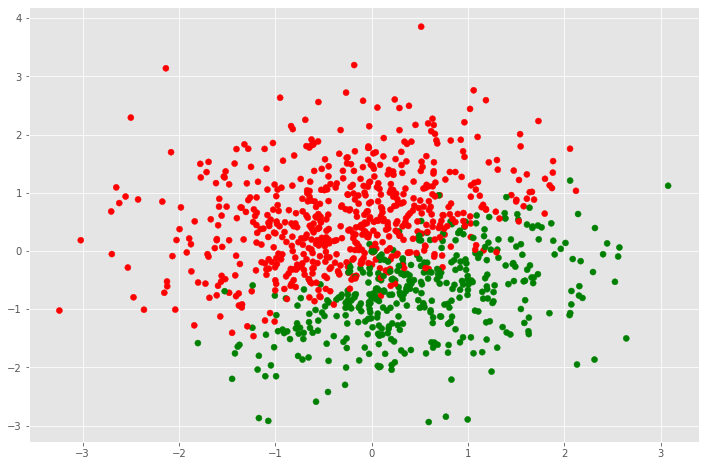

In [5]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=RdGn)
plt.show()

# 1. Классическая логистическая регрессия

In [6]:
from sklearn.linear_model import LogisticRegression

In [8]:
# penalty -- регуляризация
# C -- 1 / lambda. Чем больше C, тем меньше штраф

model = LogisticRegression(penalty='none')
model.fit(X, y)

LogisticRegression(penalty='none')

Посмотрим на получившиеся коэффициенты:

In [15]:
print('coef:', model.coef_[0, 0], model.coef_[0, 1])
print('intercept:', model.intercept_[0])

coef: 3.6160010540520897 -5.312097390295949
intercept: -1.808954541432372


Решающее правило выглядит так: `y = (coef_ @ x + intercept_) > 0`.


__Задача:__ Выразить отсюда разделяющую прямую:

In [16]:
a = -model.coef_[0, 0] / model.coef_[0, 1]
b = -model.intercept_[0] / model.coef_[0, 1]

print(f'X2 = {a:.4f} * X1 + {b: .4f}')

X2 = 0.6807 * X1 + -0.3405


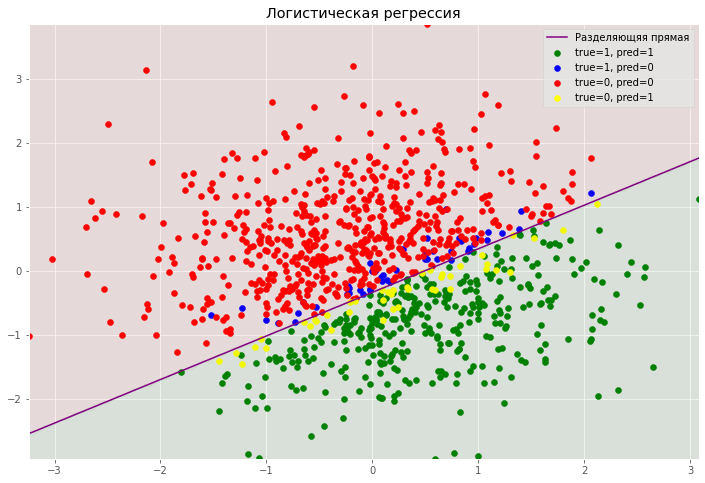

In [19]:
plot_classification(X, y, model, show_line=True, title='Логистическая регрессия')

# 2. Регуляризация в логистической регрессии

Рассмотрим 2 варианта регуляризации:
* $L_1$-регуляризация: обладает свойством отбора значимых признаков;
* $L_2$-регуляризаций: сдерживает рост коэффициентов.

In [20]:
from sklearn.datasets import make_classification

In [21]:
N = 256

X, y = make_classification(n_samples=N, 
                           n_features=10, 
                           n_informative=4, 
                           n_redundant=6, 
                           n_repeated=0,
                           class_sep=1.0,
                           scale=1,
                           n_clusters_per_class=1,
                           random_state=42)
print('X shape:', X.shape)

X shape: (256, 10)


## 2.1. $L_1$-регуляризация
Обучим логистическую регрессию с L1 регуляризацией:

In [24]:
model_l1 = LogisticRegression(penalty='l1', solver='saga', max_iter=8192, C=1)
model_l1.fit(X, y)

LogisticRegression(C=1, max_iter=8192, penalty='l1', solver='saga')

Посмотрев на коэффициенты, видим эффект отбора признаков.

In [25]:
print('Coef:', model_l1.coef_)
print('Intercept:', model_l1.intercept_)

Coef: [[ 2.22221032e+00  0.00000000e+00  0.00000000e+00  6.82713682e-01
  -3.10136708e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -4.14513921e-01 -2.12589006e-04]]
Intercept: [-0.1579022]


Построим график влияния коэффициента регуляризации на величину коэффициентов:

(128, 10)


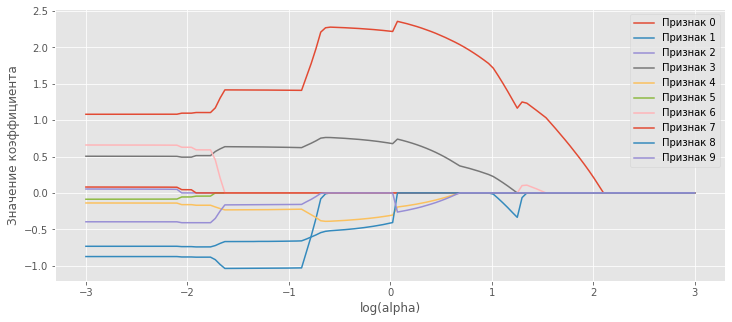

In [30]:
C_list = np.logspace(-3, 3, 128)
coef_list = []

for C in C_list:
    model_l1 = LogisticRegression(penalty='l1', solver='saga', max_iter=8192, C=1 / C)
    model_l1.fit(X, y)
    coef_list.append(model_l1.coef_[0])

coef_list = np.array(coef_list)
print(coef_list.shape)

plt.figure(figsize=(12,5))
for idx in range(coef_list.shape[1]):
    plt.plot(np.log10(C_list), coef_list[:, idx], label=f'Признак {idx}')
    
plt.xlabel('log(alpha)')
plt.ylabel('Значение коэффициента')
plt.legend()
plt.show()

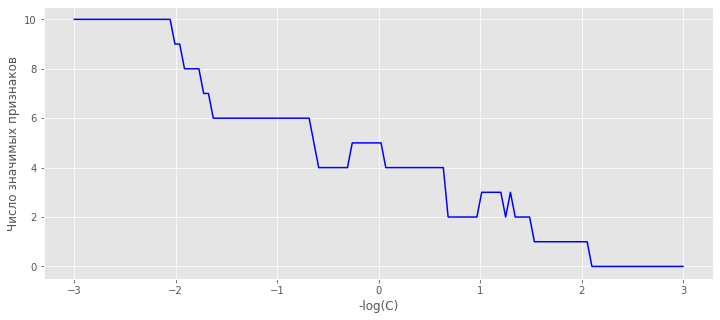

In [32]:
plt.figure(figsize=(12, 5))
plt.plot(np.log10(C_list), (np.abs(coef_list) > 0).sum(axis=1), color='blue')
plt.ylabel('Число значимых признаков')
plt.xlabel('-log(C)')
plt.show()

## 2.2. $L_2$-регуляризация

Обучим логистическую регрессию с L2 регуляризацией:

In [33]:
model_l2 = LogisticRegression(penalty='l2', C=1)
model_l2.fit(X, y)

LogisticRegression(C=1)

В этот раз все коэффициенты отличны от нуля:

In [34]:
print('Coef:', model_l2.coef_)
print('Intercept:', model_l2.intercept_)

Coef: [[ 1.0283685  -0.83423739  0.05824003  0.46684866 -0.13085778 -0.07313811
   0.63471438  0.06581971 -0.68339236 -0.35956454]]
Intercept: [-0.19283417]


Построим график влияния коэффициента регуляризации на величину коэффициентов:

(128, 10)


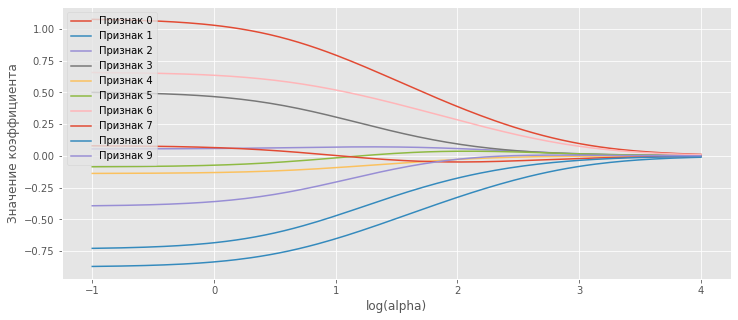

In [35]:
C_list = np.logspace(-1, 4, 128)
coef_list = []

for C in C_list:
    model_l2 = LogisticRegression(penalty='l2', C=1 / C).fit(X, y)
    coef_list.append(model_l2.coef_[0])

coef_list = np.array(coef_list)
print(coef_list.shape)

plt.figure(figsize=(12,5))
for idx in range(coef_list.shape[1]):
    plt.plot(np.log10(C_list), coef_list[:, idx], label=f'Признак {idx}')
    
plt.xlabel('log(alpha)')
plt.ylabel('Значение коэффициента')
plt.legend()
plt.show()

## 3. Случай линейно неразделимых данных

Рассмотрим теперь выборку наблюдений, сосредоточенную вокруг 2 концентрических окружностей:
* окружность радиуса 1;
* окружность радиуса 0.8.

In [38]:
N = 512

X, y = make_circles(N, random_state=42, noise=0.05, factor=0.8)

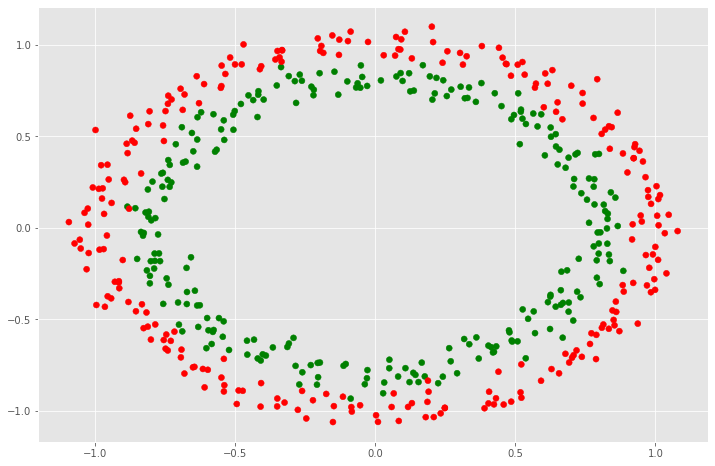

In [39]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=RdGn)
plt.show()

Обучим простую логистическую регрессию:

In [40]:
model = LogisticRegression(penalty='none')
model.fit(X, y)

LogisticRegression(penalty='none')

Смотрим коэффициенты модели:

In [42]:
print(model.coef_)
print(model.intercept_)

[[-0.00050141  0.00705557]]
[-3.1097001e-05]


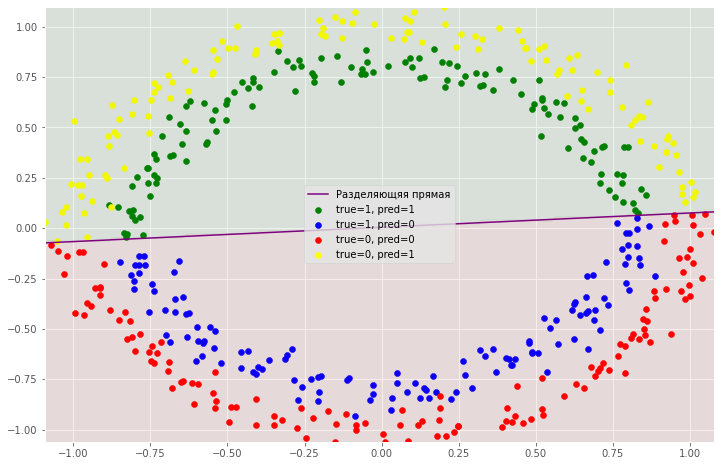

In [43]:
plot_classification(X, y, model, show_line=True)

## 3.1. Преобразование признакового пространства

Перейдем к полярным координатам:
* $X'_1 = \arctan\left(\frac{X_1}{X_2}\right)$;
* $X'_2 = \sqrt{X_1^2 + X_2^2}$.

__Задача:__ определить функцию X_transform.

In [44]:
def X_transform(X):
    return X ** 2

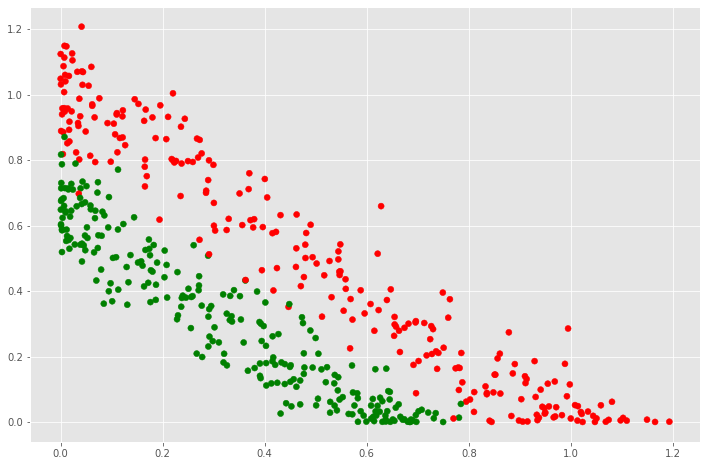

In [45]:
Xt = X_transform(X)

plt.figure()
plt.scatter(Xt[:, 0], Xt[:, 1], c=y, cmap=RdGn)
plt.show()

Обучаем модель:

In [49]:
model_polar = LogisticRegression(penalty='none')
model_polar.fit(Xt, y)

LogisticRegression(penalty='none')

In [50]:
print(model_polar.coef_)
print(model_polar.intercept_)

[[-49.16968612 -47.43371246]]
[39.19683066]


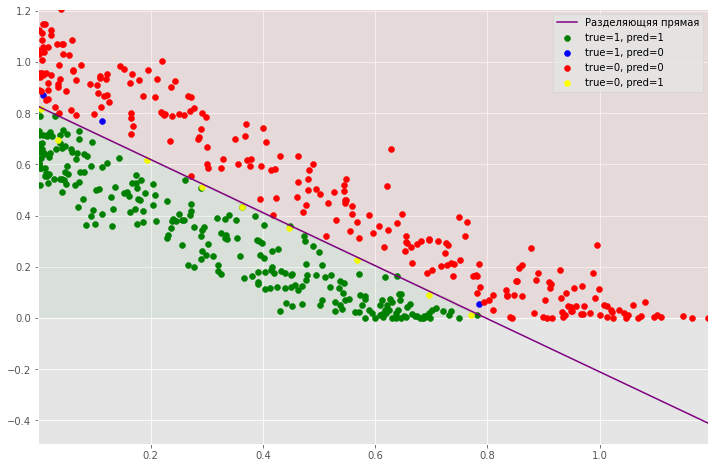

In [51]:
plot_classification(Xt, y, model_polar, show_line=True)

Построим график классификации для исходных признаков:

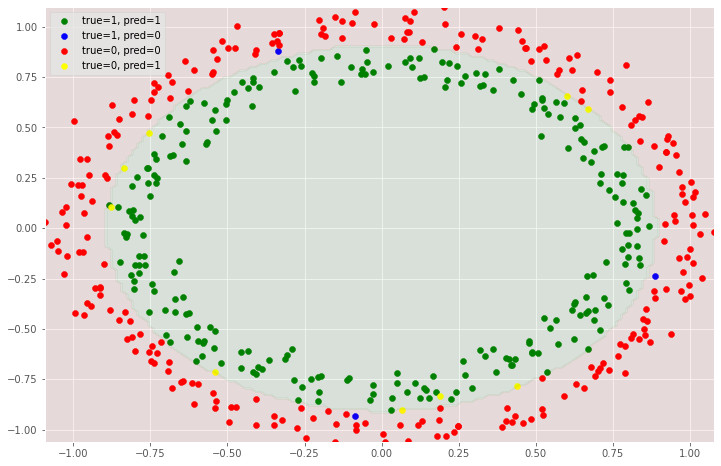

In [52]:
plot_classification(X, y, model_polar, show_line=False, X_transform=X_transform)

# 3. Оценка качества модели. Введение


__Титаник:__
* survived -- спасен или нет;
* pclass -- социально-экономический статус (1 -- upper, 2 -- middle, 3 -- lower);
* sex -- пол;
* age -- возраст;
* sibsp -- число ближайших родственников на борту (муж/жена, брат/сестра);
* parch -- число родителей/детей на борту;
* fare -- плата за проезд;
* embarked -- место посадки.

In [54]:
frame = sns.load_dataset('titanic')
frame = frame[['pclass', 'sex', 'age', 'fare', 'survived']].dropna()

print('Shape:', frame.shape)
frame.head()

Shape: (714, 5)


,pclass,sex,age,fare,survived
0,3,male,22.0,7.2500,0
1,1,female,38.0,71.2833,1
2,3,female,26.0,7.9250,1
3,1,female,35.0,53.1000,1
4,3,male,35.0,8.0500,0


Построим модель, которая будет предсказывать выживание человека.

In [86]:
X = frame[['pclass', 'sex', 'age', 'fare']].copy()
y = frame['survived'].copy()

Преобразуем категориальные признаки:

In [87]:
X.head()

,pclass,sex,age,fare
0,3,male,22.0,7.2500
1,1,female,38.0,71.2833
2,3,female,26.0,7.9250
3,1,female,35.0,53.1000
4,3,male,35.0,8.0500


In [88]:
# категориальные признаки
X['sex'] = (X.sex == 'female').astype(int)
X['pclass2'] = (X.pclass == 2).astype(int)
X['pclass1'] = (X.pclass == 1).astype(int)
X = X.drop(columns=['pclass'])
X.head()

,sex,age,fare,pclass2,pclass1
0,0,22.0,7.2500,0,0
1,1,38.0,71.2833,0,1
2,1,26.0,7.9250,0,0
3,1,35.0,53.1000,0,1
4,0,35.0,8.0500,0,0


Для того, чтобы проверить качество модели, разделим выборку на 2 части:
* Тренировочную часть будем использовать для обучения модели.
* Тестовую часть оставим для оценки качества модели.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.copy()
X_test = X_test.copy()
y_train = y_train.copy()
y_test = y_test.copy()

print('Train:', X_train.shape[0])
print('Test:', X_test.shape[0])

Train: 571
Test: 143


__Задача:__ Отнормировать числовые признаки.

In [106]:
from sklearn.preprocessing import MinMaxScaler

In [107]:
scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(X_train[['age', 'fare']])

StandardScaler()

In [108]:
X_train[['age', 'fare']] = scaler.transform(X_train[['age', 'fare']])
X_train[['age', 'fare']].describe()

,age,fare
count,5.710000e+02,5.710000e+02
mean,2.364328e-16,4.977532e-17
std,1.000877e+00,1.000877e+00
min,-2.011210e+00,-7.081945e-01
25%,-6.127307e-01,-5.456746e-01
50%,-1.030808e-01,-3.902207e-01
75%,6.104291e-01,-1.420405e-02
max,3.396515e+00,9.635125e+00


In [109]:
X_test[['age', 'fare']] = scaler.transform(X_test[['age', 'fare']])
X_test[['age', 'fare']].describe()

,age,fare
count,143.000000,143.000000
mean,-0.107833,-0.038713
std,0.928527,1.307233
min,-1.971797,-0.708195
25%,-0.748637,-0.548198
50%,-0.137057,-0.416381
75%,0.406569,-0.074518
max,2.173356,9.635125


In [110]:
X_train.describe()

,sex,age,fare,pclass2,pclass1
count,571.000000,5.710000e+02,5.710000e+02,571.000000,571.000000
mean,0.362522,2.364328e-16,4.977532e-17,0.248687,0.264448
std,0.481150,1.000877e+00,1.000877e+00,0.432631,0.441426
min,0.000000,-2.011210e+00,-7.081945e-01,0.000000,0.000000
25%,0.000000,-6.127307e-01,-5.456746e-01,0.000000,0.000000
50%,0.000000,-1.030808e-01,-3.902207e-01,0.000000,0.000000
75%,1.000000,6.104291e-01,-1.420405e-02,0.000000,1.000000
max,1.000000,3.396515e+00,9.635125e+00,1.000000,1.000000


In [111]:
X_test.describe()

,sex,age,fare,pclass2,pclass1
count,143.000000,143.000000,143.000000,143.000000,143.000000
mean,0.377622,-0.107833,-0.038713,0.216783,0.244755
std,0.486496,0.928527,1.307233,0.413502,0.431453
min,0.000000,-1.971797,-0.708195,0.000000,0.000000
25%,0.000000,-0.748637,-0.548198,0.000000,0.000000
50%,0.000000,-0.137057,-0.416381,0.000000,0.000000
75%,1.000000,0.406569,-0.074518,0.000000,0.000000
max,1.000000,2.173356,9.635125,1.000000,1.000000


Обучим логистическую регрессию:

In [113]:
model = LogisticRegression(penalty='none')
model.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [114]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

Считаем метрику __Accuracy__: `#[true == pred] / N`

__Задача:__ написать функцию, которая считает метрику accuracy.

In [115]:
def accuracy_score(true, pred):
    return (true == pred).sum() / true.shape[0]

In [116]:
print('Train accuracy:', accuracy_score(y_train, pred_train))
print('Test accuracy:', accuracy_score(y_test, pred_test))

Train accuracy: 0.8126094570928196
Test accuracy: 0.7412587412587412


## 3.1. Регуляризация и влияние на переобучение

Одним из методов борьбы с переобучением является регуляризация.

Существуют разные методы выбора регуляризации и настройки её параметров:
* метод отложенной выборки;
* метод кросс-валидации;
* байесовские методы (например, метод максимальной обоснованности).

__$L_1$-регуляризация:__

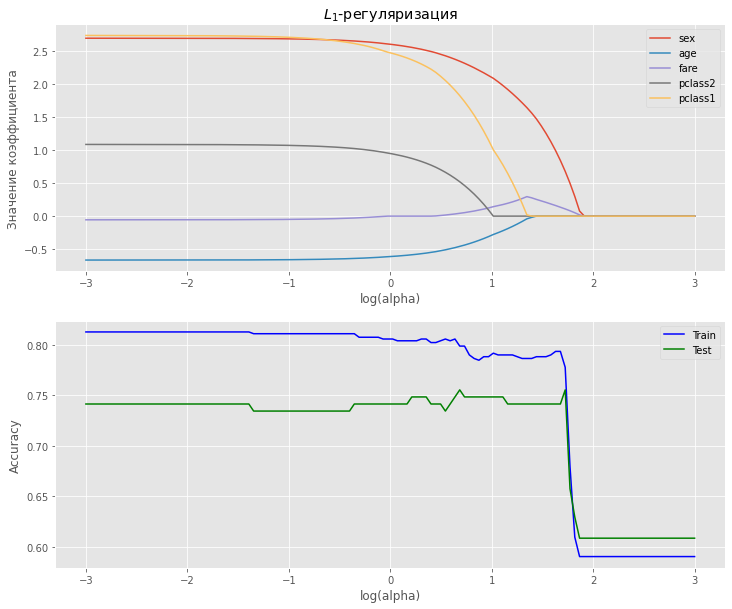

In [117]:
C_list = np.logspace(-3, 3, 128)
coef_list = []
train_acc = []
test_acc = []

for C in C_list:
    model_l1 = LogisticRegression(penalty='l1', solver='saga', max_iter=8192, C=1 / C)
    model_l1.fit(X_train, y_train)
    
    pred_train = model_l1.predict(X_train)
    pred_test = model_l1.predict(X_test)

    train_acc.append(accuracy_score(y_train, pred_train))
    test_acc.append(accuracy_score(y_test, pred_test))
    
    coef_list.append(model_l1.coef_[0])

coef_list = np.array(coef_list)

_, [ax1, ax2] = plt.subplots(2, 1, figsize=(12,10))
for idx in range(coef_list.shape[1]):
    ax1.plot(np.log10(C_list), coef_list[:, idx], label=f'{X.columns[idx]}')
    
ax2.plot(np.log10(C_list), train_acc, color='blue', label='Train')
ax2.plot(np.log10(C_list), test_acc, color='green', label='Test')

ax1.set_title('$L_1$-регуляризация')
ax1.set_xlabel('log(alpha)')
ax2.set_xlabel('log(alpha)')
ax1.set_ylabel('Значение коэффициента')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()

plt.show()

__$L_2$-регуляризация:__

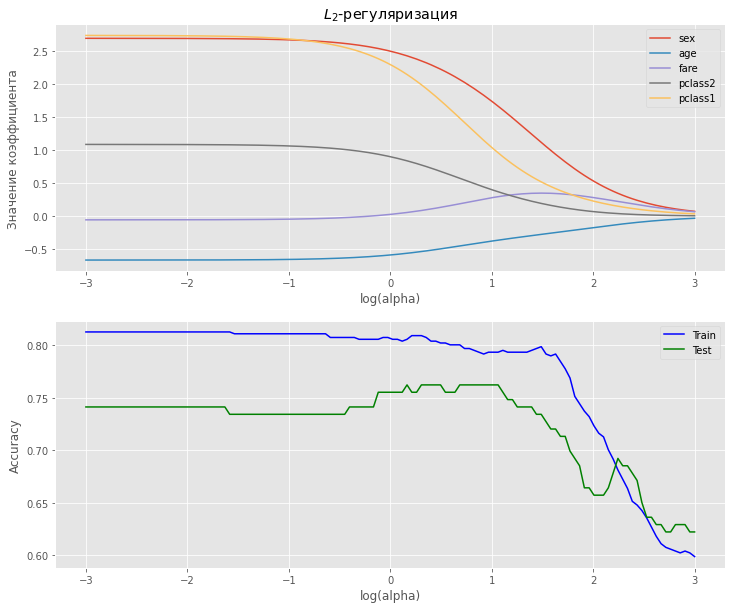

In [118]:
C_list = np.logspace(-3, 3, 128)
coef_list = []
train_acc = []
test_acc = []

for C in C_list:
    model_l2 = LogisticRegression(penalty='l2', C=1/C)
    model_l2.fit(X_train, y_train)
    
    pred_train = model_l2.predict(X_train)
    pred_test = model_l2.predict(X_test)

    train_acc.append(accuracy_score(y_train, pred_train))
    test_acc.append(accuracy_score(y_test, pred_test))
    
    coef_list.append(model_l2.coef_[0])

coef_list = np.array(coef_list)

_, [ax1, ax2] = plt.subplots(2, 1, figsize=(12,10))
for idx in range(coef_list.shape[1]):
    ax1.plot(np.log10(C_list), coef_list[:, idx], label=f'{X.columns[idx]}')
    
ax2.plot(np.log10(C_list), train_acc, color='blue', label='Train')
ax2.plot(np.log10(C_list), test_acc, color='green', label='Test')

ax1.set_title('$L_2$-регуляризация')
ax1.set_xlabel('log(alpha)')
ax2.set_xlabel('log(alpha)')
ax1.set_ylabel('Значение коэффициента')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()

plt.show()